# 2150188401(2) Deep Learning Assignment #1<br> Part 1-1. Training Convolutional Neural Networks (Pytorch)

Copyright (C) Computer Science & Engineering, Soongsil University. This material is for educational uses only. Some contents are based on the material provided by other paper/book authors and may be copyrighted by them. Written by Haneul Pyeon, September 2024.

**For understanding of this work, please carefully look at given PDF file.**

Now, you're going to leave behind your implementations and instead migrate to one of popular deep learning frameworks, **PyTorch**. <br>
In this notebook, you will learn how to train convolutional neural networks (CNNs) for classifying images in the CIFAR-10 dataset. <br>
There are **3 sections**, and in each section, you need to follow the instructions to complete the skeleton codes and explain them.

**Note**: certain details are missing or ambiguous on purpose, in order to test your knowledge on the related materials. However, if you really feel that something essential is missing and cannot proceed to the next step, then contact the teaching staff with clear description of your problem.

### Submitting your work:
<font color=red>**DO NOT clear the final outputs**</font> so that TAs can grade both your code and results.

### Some helpful tutorials and references for assignment #1-1:
- [1] Pytorch official documentation. [[link]](https://pytorch.org/docs/stable/index.html)
- [2] Stanford CS231n lectures. [[link]](http://cs231n.stanford.edu/)
- [3] Szegedy et al., "Going deeper with convolutions", CVPR 2015. [[pdf]](http://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Szegedy_Going_Deeper_With_2015_CVPR_paper.pdf)

## 1. Load datasets
The CIFAR-10 dataset will be downloaded automatically if it is not located in the *data* directory. <br>

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset_train = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=8,
                                          shuffle=True, num_workers=2)

dataset_test = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=8,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:04<00:00, 42141887.94it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

In [4]:
# function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    print(np.transpose(npimg, (1, 2, 0)).shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

(36, 274, 3)


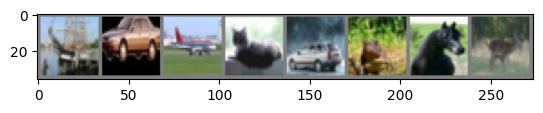

 ship   car plane   cat
torch.Size([3, 32, 32])


In [5]:
# get some random training images
images, labels = next(iter(dataloader_train))

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))
# print size of single image
print(images[1].shape)

## 2. Training a small CNN model

#### CNN architecture in order:
* 7x7 Convolutional layer with 8 filters, strides of 1, and ReLU activation
* 2x2 Max pooling layer with strides of 2
* 4x4 Convolutional layer with 16 filters, strides of 1, and ReLU activation
* 2x2 Max pooling layer with strides of 2
* Fully connected layer with 100 output units and ReLU activation
* Fully connected layer with 80 output units and ReLU activation
* Fully connected layer with 10 output units
* You can use any padding option.

#### Training setup:
* Loss function: Softmax cross entropy
* Optimizer: Gradient descent with 0.001 learning rate
* Batch size: 8
* Training epoch: 2

### Conv2d Function
- Applies a 2D convolution over an input signal composed of several input planes.

#### Parameters
- in_channels (int) – Number of channels in the input image

- out_channels (int) – Number of channels produced by the convolution

- kernel_size (int or tuple) – Size of the convolving kernel

- stride (int or tuple, optional) – Stride of the convolution. Default: 1

- padding (int, tuple or str, optional) – Padding added to all four sides of the input. Default: 0

- padding_mode (str, optional) – 'zeros', 'reflect', 'replicate' or 'circular'. Default: 'zeros'

- dilation (int or tuple, optional) – Spacing between kernel elements. Default: 1

- groups (int, optional) – Number of blocked connections from input channels to output channels. Default: 1

- bias (bool, optional) – If True, adds a learnable bias to the output. Default: True

(link) https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

In [6]:
example_conv = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=1)
print(example_conv)

Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


### MaxPool1d Function
 - Applies a 1D max pooling over an input signal composed of several input planes.

#### Parameters
- kernel_size (Union[int, Tuple[int]]) – The size of the sliding window, must be > 0.

- stride (Union[int, Tuple[int]]) – The stride of the sliding window, must be > 0. Default value is kernel_size.

- padding (Union[int, Tuple[int]]) – Implicit negative infinity padding to be added on both sides, must be >= 0 and <= kernel_size / 2.

- dilation (Union[int, Tuple[int]]) – The stride between elements within a sliding window, must be > 0.

- return_indices (bool) – If True, will return the argmax along with the max values. Useful for torch.nn.MaxUnpool1d later

- ceil_mode (bool) – If True, will use ceil instead of floor to compute the output shape. This ensures that every element in the input tensor is covered by a sliding window.

(link) https://pytorch.org/docs/stable/generated/torch.nn.MaxPool1d.html

In [7]:
example_MaxPool2d = nn.MaxPool2d(kernel_size=2, stride=2)
print(example_MaxPool2d)

MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


In [8]:
# Define a CNN model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__() # It is the part where the structure (layers) of the neural network is defined.

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=7, stride=1) # 8 filters, 7x7 Convolutional layer, stride of 1

        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 2x2 Max pooling layer with strides of 2

        # 4x4 Convolutional layer with 16 filters, strides of 1, and ReLU activation
        # YOUR CODE
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=4, stride=1)
        # 2x2 Max pooling layer with strides of 2
        # YOUR CODE
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # nn.Linear(input, output) / input = channels * height * width
        self.fc1 = nn.Linear(16 * 5 * 5, 100) # Fully connected layer with 100 output units and ReLU activation

        # Fully connected layer with 80 output units and ReLU activation
        # YOUR CODE
        self.fc2 = nn.Linear(100, 80)
        # Fully connected layer with 10 output units
        # YOUR CODE
        self.fc3 = nn.Linear(80, 10)

    def forward(self, x): # Write how to define the flow of data through the model for training.

        x = F.relu(self.conv1(x)) #ReLU activation
        x = self.maxpool1(x)

        x = F.relu(self.conv2(x))
        x = self.maxpool2(x)

        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        ##############################################################################
        #                          END OF YOUR CODE                                  #
        ##############################################################################

        return x


In [9]:
# Function to train the network

def train(net, dataloader_train, max_epoch, crit, optimizer, device, model_path='./cifar_net.pth'):
    # add for visualization
    train_losses = []

    for epoch in range(max_epoch):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(dataloader_train, 0):
            # get the inputs; data is a list of [inputs, targets]
            inputs, targets = data

            # Training on GPU
            inputs = inputs.to(device)
            targets = targets.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs) # net(inputs) == net.forward(inputs)
            loss = crit(outputs, targets)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

        # add for visualization
        epoch_loss = running_loss / len(dataloader_train)
        train_losses.append(epoch_loss)

    print('Finished Training')
    torch.save(net.state_dict(), model_path)
    print('Saved Trained Model')

    return train_losses

### CrossEntropyLoss Function

- This criterion computes the cross entropy loss between input logits and target.

- It is useful when training a classification problem with C classes. If provided, the optional argument weight should be a 1D Tensor assigning weight to each of the classes. This is particularly useful when you have an unbalanced training set.

- The CrossEntropyLoss function internally combines Softmax and Negative Log-Likelihood Loss (NLLLoss). Therefore, when using CrossEntropyLoss, there is no need for the user to apply Softmax to the input tensor directly.

In [10]:
PATH = './cifar_net.pth'
epoch = 2

# initialize model
net = Net()

# Training on GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)

# Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

train(net, dataloader_train, epoch, criterion, optimizer, device, PATH)

[1,  2000] loss: 2.212
[1,  4000] loss: 1.780
[1,  6000] loss: 1.594
[2,  2000] loss: 1.482
[2,  4000] loss: 1.421
[2,  6000] loss: 1.381
Finished Training
Saved Trained Model


[0.06089050327301025, 0.052970834798812864]

In [11]:
# function to calculate accuracy
def print_accuracy(net, dataloader):
    correct = 0
    total = 0

    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            # Inference on GPU
            images = images.to(device)
            labels = labels.to(device)

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the %d test images: %d %%' % (total,
        100 * correct / total))

In [12]:
# load trained model then test
net.load_state_dict(torch.load(PATH))
print_accuracy(net, dataloader_test)

<ipython-input-12-17bdbaab9414>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(PATH))


Accuracy of the network on the 10000 test images: 47 %


## <a name="3-1"></a>3-1. Design an Inception module

In this section, you will implement a little more complex CNN model with an `Inception module`. <br>

![Inception_module](imgs/Inception.png)

Using the code provided as guidance, <br>
Define an `inception module`, which is the building block of **Inception model (a.k.a GoogLeNet)**, the winner of ILSVRC14. <br>


#### CNN architecture:
* CNN model consists with stem layer, inception module, and fully connected layer
* Stem layer with
    * conv-pooling-conv-pooling
    * 8 filters for the 9x9 convolutions
    * 3x3 max pooling
* `Inception module` with
    * 3(or 4) main convolutions (blue blocks in the Figure(a))
    * 3 dimensionality reduction convolutions (yellow blocks in the Figure(a))
    * 3x3 max pooling block (red blocks in the Figure(a))
    * Batch Nomalization and ReLU activation after all conv layer
* Fully connected layer with 10 output units and linear activation
* Choose the proper padding option on your own.

### Sequential Fucntion

- A sequential container.

- Modules will be added to it in the order they are passed in the constructor. Alternatively, an OrderedDict of modules can be passed in. The forward() method of Sequential accepts any input and forwards it to the first module it contains. It then “chains” outputs to inputs sequentially for each subsequent module, finally returning the output of the last module.

In [13]:
example_model = nn.Sequential(
          nn.Conv2d(1,20,5),
          nn.ReLU(),
          nn.Conv2d(20,64,5),
          nn.ReLU()
        )
print(example_model)

Sequential(
  (0): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): Conv2d(20, 64, kernel_size=(5, 5), stride=(1, 1))
  (3): ReLU()
)


### BatchNorm2d Function

- Applies Batch Normalization over a 4D input. 4D is a mini-batch of 2D inputs with additional channel dimension

#### Parameters
- num_features (int) – C from an expected input of size (N,C,H,W)

- eps (float) – a value added to the denominator for numerical stability. Default: 1e-5

- momentum (Optional[float]) – the value used for the running_mean and running_var computation. Can be set to None for cumulative moving average (i.e. simple average). Default: 0.1

- affine (bool) – a boolean value that when set to True, this module has learnable affine parameters. Default: True

- track_running_stats (bool) – a boolean value that when set to True, this module tracks the running mean and variance, and when set to False, this module does not track such statistics, and initializes statistics buffers running_mean and running_var as None. When these buffers are None, this module always uses batch statistics. in both training and eval modes. Default: True

(link) https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html

In [14]:
example_BatchN = nn.BatchNorm2d(100)
print(example_BatchN)

BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [15]:
'''
About parameter
in_planes : # of input channel
n1xn1 : # of output channel for first branch
n3xn3_blue : # of output channel for second branch's 1x1 conv layer
n3xn3 : # of output channel for second branch
n5xn5_blue : # of output channel for third branch's 1x1 conv layer
n5xn5 : # of output channel for third branch
pool_planes : # of output channel for fourth branch

'''
class Inception(nn.Module):
    def __init__(self, in_planes, n1x1, n3x3_blue, n3x3, n5x5_blue, n5x5, pool_planes):
        super(Inception, self).__init__()
        ##############################################################################
        #                          IMPLEMENT YOUR CODE                               #
        ##############################################################################
        # 1x1 conv branch
        self.b1 = nn.Sequential(
            nn.Conv2d(in_planes, n1x1, kernel_size=1),
            nn.BatchNorm2d(n1x1),
            nn.ReLU(True)
        )

        # 1x1 conv -> 3x3 conv branch
        self.b2 = nn.Sequential(
            nn.Conv2d(in_planes, n3x3_blue, kernel_size=1),
            nn.BatchNorm2d(n3x3_blue),
            nn.ReLU(True),
            nn.Conv2d(n3x3_blue, n3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(n3x3),
            nn.ReLU(True)
        )

        # 1x1 conv -> 5x5 conv branch
        self.b3 = nn.Sequential(
            nn.Conv2d(in_planes, n5x5_blue, kernel_size=1),
            nn.BatchNorm2d(n5x5_blue),
            nn.ReLU(True),
            nn.Conv2d(n5x5_blue, n5x5, kernel_size=5, padding=2),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(True)
        )

        # 3x3 pool -> 1x1 conv branch
        self.b4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_planes, pool_planes, kernel_size=1),
            nn.BatchNorm2d(pool_planes),
            nn.ReLU(True)
        )

        ##############################################################################
        #                          END OF YOUR CODE                                  #
        ##############################################################################
    def forward(self, x):
        y1 = self.b1(x)
        y2 = self.b2(x)
        y3 = self.b3(x)
        y4 = self.b4(x)
        return torch.cat([y1,y2,y3,y4], 1)

## <a name="3-2"></a>3-2. Design an Residual Block module

In this section, you will implement a little more complex CNN model with a `Residual block`. <br>

![Residual_block](imgs/Residualblock.png)

Using the code provided as guidance, <br>
Define a `residual block module`, which is the building block of **Residual neural network (a.k.a ResNet)**, the winner of ILSVRC15. <br>


#### CNN architecture:
* A residual block consists of convolutional layers, bach normalization, ReLU actication functions, and Shortcut Connection.
* Define the Short Connection which directly connects the input of the block to the output.
* The shortcut module must be sequential layers that contain:
    * 1 convolution of kernel size 1
    * 1 batch normalization layer

### Identity Function

- A placeholder identity operator that is argument-insensitive.

(link) https://pytorch.org/docs/stable/generated/torch.nn.Identity.html

In [16]:


# Define the residual block class
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        # The first convolutional layer
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        # The second convolutional layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection (identity mapping)
        if stride != 1 or in_channels != out_channels:
            ##############################################################################
            #                        IMPLEMENT OF YOUR CODE                       #
            ##############################################################################

            # matching by using 1x1 convolution
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

            ##############################################################################
            #                           END OF YOUR CODE                          #
            ##############################################################################
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        # Pass through the first convolutional layer
        out = self.conv1(x)
        out = self.bn1(out)
        out = nn.ReLU()(out)

        # Pass through the second convolutional layer
        out = self.conv2(out)
        out = self.bn2(out)

        # Shortcut connection
        shortcut = self.shortcut(x)

        # Add the output and the shortcut and pass it through a relu activation layer for the final output. (Residual connection implementation)
        ##############################################################################
            #                        IMPLEMENT OF YOUR CODE                       #
        ##############################################################################

        out += shortcut
        out = nn.ReLU()(out)

        ##############################################################################
            #                        IMPLEMENT OF YOUR CODE                       #
        ##############################################################################
        return out

## <a name="3-3"></a>3-3. Design a better model on CIFAR-10

Now it's your job to experiment with CNNs to train a model that achieves **<font color=red>>= 70% accuracy on the validation set</font>** of CIFAR-10. <br> You can reuse the implemented functions from above.

### Things you can try to change:
- Filter size
- Number of filters
- Pooling vs Strided Convolution
- Network architectures
- Optimizers
- Activation functions
- Regularizations
- Model ensembles
- Data augmentation
- learning rate scheduler

In [21]:
# Define a CNN model
class BetterNet(nn.Module):
    def __init__(self):
        super(BetterNet, self).__init__()
        ##############################################################################
        #                          IMPLEMENT YOUR CODE                               #
        ##############################################################################

        # 첫 번째 컨볼루션 레이어
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # 두 번째 컨볼루션 레이어
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # 세 번째 컨볼루션 레이어
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)


        ##############################################################################
        #                          END OF YOUR CODE                                  #
        ##############################################################################

    def forward(self, x):
        ##############################################################################
        #                          IMPLEMENT YOUR CODE                               #
        ##############################################################################

        # 첫 번째 블록: Conv -> BatchNorm -> ReLU -> Pooling
        x = self.pool(F.relu(self.bn1(self.conv1(x))))

        # 두 번째 블록: Conv -> BatchNorm -> ReLU -> Pooling
        x = self.pool(F.relu(self.bn2(self.conv2(x))))

        # 세 번째 블록: Conv -> BatchNorm -> ReLU -> Pooling
        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        # Flatten layer
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        out = self.fc2(x)

        ##############################################################################
        #                          END OF YOUR CODE                                  #
        ##############################################################################
        return out


In [22]:
# initialize model
betternet = BetterNet()
betternet = betternet.to(device)

# Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(betternet.parameters(), lr=0.001, momentum=0.9)

PATH = './better_net.pth'
# Train
train_losses = train(betternet, dataloader_train, 10, criterion, optimizer, device, PATH)
# Test
betternet.load_state_dict(torch.load(PATH))
print_accuracy(betternet, dataloader_test)

[1,  2000] loss: 1.483
[1,  4000] loss: 1.171
[1,  6000] loss: 1.038
[2,  2000] loss: 0.892
[2,  4000] loss: 0.851
[2,  6000] loss: 0.828
[3,  2000] loss: 0.714
[3,  4000] loss: 0.705
[3,  6000] loss: 0.682
[4,  2000] loss: 0.591
[4,  4000] loss: 0.597
[4,  6000] loss: 0.589
[5,  2000] loss: 0.485
[5,  4000] loss: 0.507
[5,  6000] loss: 0.516
[6,  2000] loss: 0.407
[6,  4000] loss: 0.420
[6,  6000] loss: 0.433
[7,  2000] loss: 0.343
[7,  4000] loss: 0.370
[7,  6000] loss: 0.370
[8,  2000] loss: 0.264
[8,  4000] loss: 0.287
[8,  6000] loss: 0.305
[9,  2000] loss: 0.207
[9,  4000] loss: 0.229
[9,  6000] loss: 0.254
[10,  2000] loss: 0.160
[10,  4000] loss: 0.171
[10,  6000] loss: 0.206
Finished Training
Saved Trained Model


<ipython-input-22-df36b0d733f1>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  betternet.load_state_dict(torch.load(PATH))


Accuracy of the network on the 10000 test images: 79 %


### Describe what you did here
In this cell you should also write an explanation of what you did, any additional features that you implemented, and any visualizations or graphs that you make in the process of training and evaluating your network.

You can write in Korean or English


1.   컨볼루션 레이어 -> 피처 추출
2.   배치정규화 적용 -> 오버피팅 예방
3.   맥스 풀링 -> 크기 줄임

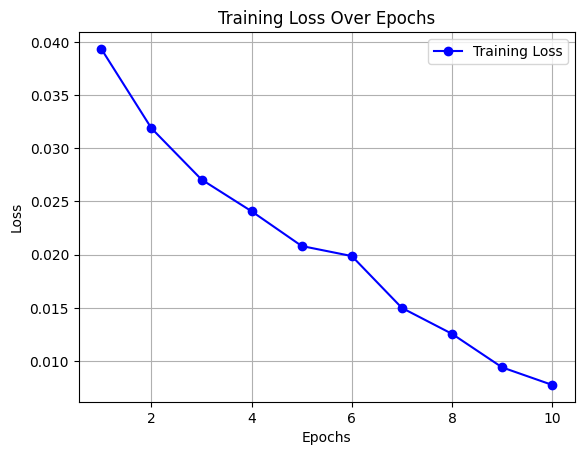

In [23]:
# for visualization
epochs = range(1, len(train_losses) + 1)  # 에폭 번호 리스트
plt.plot(epochs, train_losses, label='Training Loss', color='blue', marker='o')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()